# **Regork Midterm Project**
**Presented By:**
- Adam Laughlin
- Finnian Kephart
- Finnian Traubert
- Jack Magee

## **Introduction**
Project Description

## **Setup Data**

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from completejourney_py import get_data


In [3]:
# Needed tables
data = get_data([
    "transactions",
    "coupon_redemptions",
    "demographics",
    "campaigns",
    "campaign_descriptions"
])

transactions = data["transactions"].copy()
coupon_redemptions = data["coupon_redemptions"].copy()
demographics = data["demographics"].copy()
campaigns = data["campaigns"].copy()
campaign_descriptions = data["campaign_descriptions"].copy()

print("transactions:", transactions.shape)
print("coupon_redemptions:", coupon_redemptions.shape)
print("demographics:", demographics.shape)


transactions: (1469307, 11)
coupon_redemptions: (2102, 4)
demographics: (801, 8)


In [4]:
# Basic cleaning + project metrics
transactions["transaction_timestamp"] = pd.to_datetime(
    transactions["transaction_timestamp"], errors="coerce"
)

transactions["discount"] = (
    transactions["coupon_disc"].fillna(0)
    + transactions["coupon_match_disc"].fillna(0)
    + transactions["retail_disc"].fillna(0)
)

transactions["net_spend"] = transactions["sales_value"].fillna(0) - transactions["discount"]

transactions.head()


,household_id,store_id,basket_id,product_id,quantity,sales_value,retail_disc,coupon_disc,coupon_match_disc,week,transaction_timestamp,discount,net_spend
0,900,330,31198570044,1095275,1,0.50,0.00,0.0,0.0,1,2017-01-01 11:53:26,0.00,0.50
1,900,330,31198570047,9878513,1,0.99,0.10,0.0,0.0,1,2017-01-01 12:10:28,0.10,0.89
2,1228,406,31198655051,1041453,1,1.43,0.15,0.0,0.0,1,2017-01-01 12:26:30,0.15,1.28
3,906,319,31198705046,1020156,1,1.50,0.29,0.0,0.0,1,2017-01-01 12:30:27,0.29,1.21
4,906,319,31198705046,1053875,2,2.78,0.80,0.0,0.0,1,2017-01-01 12:30:27,0.80,1.98


In [5]:
# Household-level totals
hh_summary = (
    transactions.groupby("household_id", as_index=False)
    .agg(
        total_spend=("sales_value", "sum"),
        total_discount=("discount", "sum"),
        total_net_spend=("net_spend", "sum"),
        total_trips=("basket_id", "nunique"),
        total_units=("quantity", "sum")
    )
)

hh_summary["avg_basket_spend"] = np.where(
    hh_summary["total_trips"] > 0,
    hh_summary["total_spend"] / hh_summary["total_trips"],
    np.nan
)

hh_summary["roi_proxy"] = np.where(
    hh_summary["total_discount"] > 0,
    hh_summary["total_net_spend"] / hh_summary["total_discount"],
    np.nan
)

hh_summary.head()


,household_id,total_spend,total_discount,total_net_spend,total_trips,total_units,avg_basket_spend,roi_proxy
0,1,2415.56,442.17,1973.39,51,1131,47.363922,4.462967
1,2,1024.12,164.70,859.42,20,406,51.206000,5.218094
2,3,1026.63,275.41,751.22,20,7568,51.331500,2.727642
3,4,442.14,41.78,400.36,18,144,24.563333,9.582575
4,5,299.67,34.19,265.48,20,95,14.983500,7.764844


In [6]:
# Redeemer flag + redemption count per household
redemption_counts = (
    coupon_redemptions.groupby("household_id", as_index=False)
    .size()
    .rename(columns={"size": "redemption_count"})
)

hh_summary = hh_summary.merge(redemption_counts, on="household_id", how="left")
hh_summary["redemption_count"] = hh_summary["redemption_count"].fillna(0).astype(int)
hh_summary["redeemer"] = (hh_summary["redemption_count"] > 0).astype(int)

hh_summary[["household_id", "redeemer", "redemption_count"]].head()


,household_id,redeemer,redemption_count
0,1,1,5
1,2,0,0
2,3,0,0
3,4,0,0
4,5,0,0


In [7]:
# Merge demographics (base table for Q2/Q3)
analysis_df = hh_summary.merge(demographics, on="household_id", how="left")

print("households:", analysis_df["household_id"].nunique())
print("redeemers:", analysis_df["redeemer"].sum())
print("non-redeemers:", (analysis_df["redeemer"] == 0).sum())

analysis_df.head()


households: 2469
redeemers: 410
non-redeemers: 2059


,household_id,total_spend,total_discount,total_net_spend,total_trips,total_units,avg_basket_spend,roi_proxy,redemption_count,redeemer,age,income,home_ownership,marital_status,household_size,household_comp,kids_count
0,1,2415.56,442.17,1973.39,51,1131,47.363922,4.462967,5,1,65+,35-49K,Homeowner,Married,2,2 Adults No Kids,0
1,2,1024.12,164.70,859.42,20,406,51.206000,5.218094,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1026.63,275.41,751.22,20,7568,51.331500,2.727642,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,442.14,41.78,400.36,18,144,24.563333,9.582575,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,299.67,34.19,265.48,20,95,14.983500,7.764844,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Q1: Are coupon redeemers associated with higher total purchase amount than non-redeemers?**

### **Q2: Which demographic segments (age, income, household composition, kids) have the highest total spend among coupon redeemers?**

### **Q3: Which demographic segments have the highest net spend and ROI proxy among coupon redeemers?**

In [13]:
# --- Q3: Segment performance among coupon redeemers ---

# 1 Filter to coupon redeemers only
redeemers_df = analysis_df[analysis_df["redeemer"] == 1].copy()

# 2️ Choose demographic segment to analyze
# (Change this variable to test others: age, household_size, kids_count, etc.)
segment_var = "income"

# 3️ Compute segment-level metrics
segment_summary = (
    redeemers_df.groupby(segment_var, dropna=False)
    .agg(
        avg_net_spend=("total_net_spend", "mean"),
        avg_roi_proxy=("roi_proxy", "mean"),
        household_count=("household_id", "count")
    )
)

# 4️ Rank segments
top_net_spend = segment_summary.sort_values(
    "avg_net_spend", ascending=False
).head(5)

top_roi_proxy = segment_summary.sort_values(
    "avg_roi_proxy", ascending=False
).head(5)

# 5️ Output
print("Top 5 Segments by Net Spend:")
display(top_net_spend)

print("\nTop 5 Segments by ROI Proxy:")
display(top_roi_proxy)

Top 5 Segments by Net Spend:


,avg_net_spend,avg_roi_proxy,household_count
income,,,
250K+,8634.830000,6.229952,2
125-149K,5066.606316,5.896536,19
175-199K,5025.504000,6.558079,5
150-174K,4825.176471,6.255630,17
75-99K,4055.860323,5.282519,31



Top 5 Segments by ROI Proxy:


,avg_net_spend,avg_roi_proxy,household_count
income,,,
175-199K,5025.504000,6.558079,5
150-174K,4825.176471,6.255630,17
250K+,8634.830000,6.229952,2
125-149K,5066.606316,5.896536,19
75-99K,4055.860323,5.282519,31


#### Graph for Q3

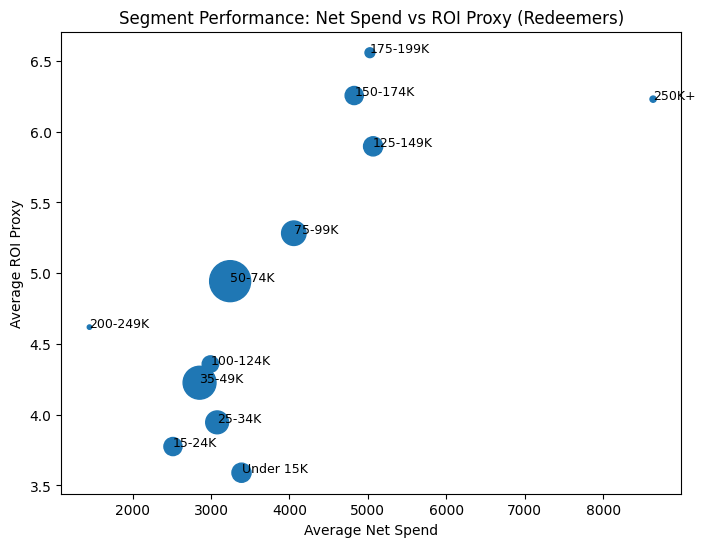

In [9]:
# Prepare segment summary (reuse from Q3)
segment_var = "income"

segment_summary = (
    analysis_df[analysis_df["redeemer"] == 1]
    .groupby(segment_var)
    .agg(
        avg_net_spend=("total_net_spend", "mean"),
        avg_roi_proxy=("roi_proxy", "mean"),
        household_count=("household_id", "count")
    )
    .reset_index()
)

# Scatter plot
plt.figure(figsize=(8, 6))

plt.scatter(
    segment_summary["avg_net_spend"],
    segment_summary["avg_roi_proxy"],
    s=segment_summary["household_count"] * 10,  # bubble size
)

# Label each point with segment name
for _, row in segment_summary.iterrows():
    plt.text(
        row["avg_net_spend"],
        row["avg_roi_proxy"],
        row[segment_var],
        fontsize=9
    )

plt.xlabel("Average Net Spend")
plt.ylabel("Average ROI Proxy")
plt.title("Segment Performance: Net Spend vs ROI Proxy (Redeemers)")
plt.show()

In [10]:
# Count households with specified income ranges
inc_series = analysis_df["income"].astype(str).str.strip().replace({"nan": ""})
count_200_249 = (inc_series == "200-249k").sum()
count_250_plus = (inc_series == "250k+").sum()

print("households with income 200-249k:", count_200_249)
print("households with income 250k+:", count_250_plus)

households with income 200-249k: 0
households with income 250k+: 0


### **Q4: Among coupon redeemers, is higher spend associated more with more shopping trips or larger basket size?**

### **Q5:Are heavy coupon redeemers less efficient than moderate redeemers?**

## **Conclusion/Findings:**